# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных:

**Признаки**<br />
RowNumber — индекс строки в данных<br />
CustomerId — уникальный идентификатор клиента<br />
Surname — фамилия<br />
CreditScore — кредитный рейтинг<br />
Geography — страна проживания<br />
Gender — пол<br />
Age — возраст<br />
Tenure — сколько лет человек является клиентом банка<br />
Balance — баланс на счёте<br />
NumOfProducts — количество продуктов банка, используемых клиентом<br />
HasCrCard — наличие кредитной карты<br />
IsActiveMember — активность клиента<br />
EstimatedSalary — предполагаемая зарплата<br />
**Целевой признак**<br />
Exited — факт ухода клиента<br />

# Вспомогательные функции:

### Импорт библиотек

In [1]:
!pip install imbalanced-learn

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

%matplotlib notebook
%matplotlib inline

In [3]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None


Отключение вывода в окно с прокруткой:

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Информация о столбцах:

In [5]:
data_name = 'Данные об клиентах'
data_fields = {
'RowNumber':['Индекс строки в данных', False],
'CustomerId':['Уникальный идентификатор клиента', False],
'Surname':['Фамилия', False],
'CreditScore':['Кредитный рейтинг', True],
'Geography':['Страна проживания', True],
'Gender':['Пол', True],
'Age':['Возраст', True],
'Tenure':['Сколько лет человек является клиентом банка', True],
'Balance':['Баланс на счёте', True],
'NumOfProducts':['Количество продуктов банка, используемых клиентом', True],
'HasCrCard':['Наличие кредитной карты', True],
'IsActiveMember':['Активность клиента', True],
'EstimatedSalary':['Предполагаемая зарплата', True],
'Exited':['Факт ухода клиента', True]
}    


### Функция, создающая таблицу по данным describe() для столбцов датафрейма

In [6]:
def describer(df,clmn='column'):
    df_describe = pd.DataFrame(columns=[clmn,'count','mean','std','min','25%','50%','75%','max'])
    for col in df.columns:
        param = df[col]
        typer = type(list(param)[0]) #[0])
        if (not 'str' in str(typer)) and (not 'bool' in str(typer)) and (not 'date' in str(typer)):
            desc = df[col].describe().to_dict()
            desc[clmn] = col
            df_describe = df_describe.append(desc, ignore_index=True)
    return df_describe

### Функция получения информации о столбце

In [7]:
def col_reaper(ddf,param_name,plot_hist = True):
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    
    #Определение имени столбца
    if data_fields.get(param_name)[0] is not None:
        field = data_fields.get(param_name)[0]
    else:
        field = ''
        
    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
    if plot_hist and not 'str' in str(typer):
#        print('\nГистограмма значений:')
        param.hist();
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',figsize=(16,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(16,5))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')
    

### Функция получения информации о датафрейме

In [8]:
def df_reaper(df, df_name ='', data_fields = {}):
    #global data_fields
    #global df_name
    #global descript
    
    # Список столюцов для гистограмм, диаграмм, корелляции и т.п.
    cols = df.columns
    true_cols = []
    for col in cols:
        if data_fields.get(col)[1]:
            true_cols.append(col)

    
    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    display(describer(df[true_cols]))

    print('\033[1m' +  'Диаграмма рассеивания:' + '\033[0m')
    pd.plotting.scatter_matrix(df[true_cols], figsize=(16, 16)); 
    plt.show()
    
    print('\033[1m' +  'Корелляция данных:' + '\033[0m')
#    display(df[true_cols].corr())
    
    plt.figure(figsize=(16, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df[true_cols].corr(), dtype=np.bool))
    heatmap = sns.heatmap(df[true_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    #heatmap.set_title('Корелляция данных', fontdict={'fontsize':18}, pad=16);
    plt.show()
    
    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
 #   cols = df.columns

    for col in cols:
        if data_fields.get(col)[0] is not None:
            field = data_fields.get(col)[0]
        else:
            field = ''
        print('\033[1;3m' +  col + ' - ' + field + '\033[0m')
        plot_hist = data_fields.get(col)[1]
        col_reaper(df,col,plot_hist)

In [9]:
data_fields

{'RowNumber': ['Индекс строки в данных', False],
 'CustomerId': ['Уникальный идентификатор клиента', False],
 'Surname': ['Фамилия', False],
 'CreditScore': ['Кредитный рейтинг', True],
 'Geography': ['Страна проживания', True],
 'Gender': ['Пол', True],
 'Age': ['Возраст', True],
 'Tenure': ['Сколько лет человек является клиентом банка', True],
 'Balance': ['Баланс на счёте', True],
 'NumOfProducts': ['Количество продуктов банка, используемых клиентом', True],
 'HasCrCard': ['Наличие кредитной карты', True],
 'IsActiveMember': ['Активность клиента', True],
 'EstimatedSalary': ['Предполагаемая зарплата', True],
 'Exited': ['Факт ухода клиента', True]}

## **Подготовка данных**

### Загрузка данных

In [10]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


### Анализ данных

Данные об клиентах 

Количество записей:


10000


Первые 5 строк данных:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Описание данных в столбцах с числовыми значениями:


,column,count,mean,std,min,25%,50%,75%,max
0,CreditScore,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
1,Age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
2,Tenure,"9,091.00",5.00,2.89,0.00,2.00,5.00,7.00,10.00
3,Balance,"10,000.00","76,485.89","62,397.41",0.00,0.00,"97,198.54","127,644.24","250,898.09"
4,NumOfProducts,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
5,HasCrCard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
6,IsActiveMember,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
7,EstimatedSalary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"
8,Exited,"10,000.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


Диаграмма рассеивания:


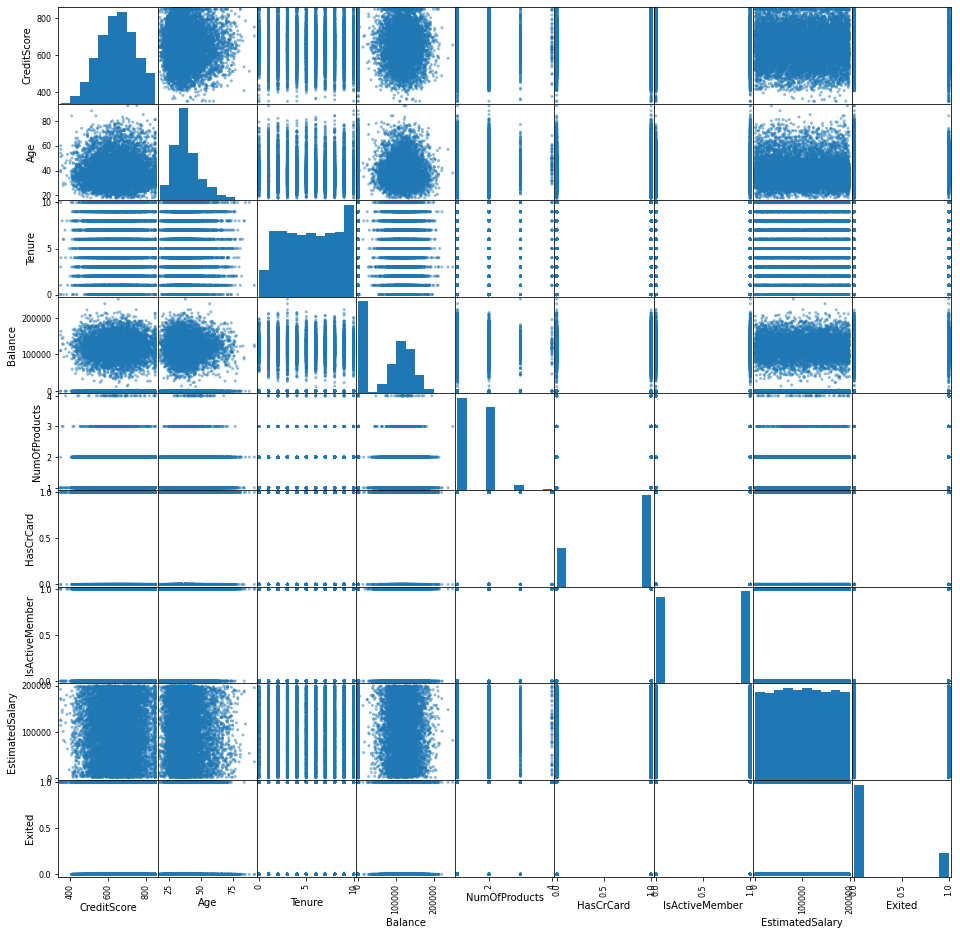

Корелляция данных:


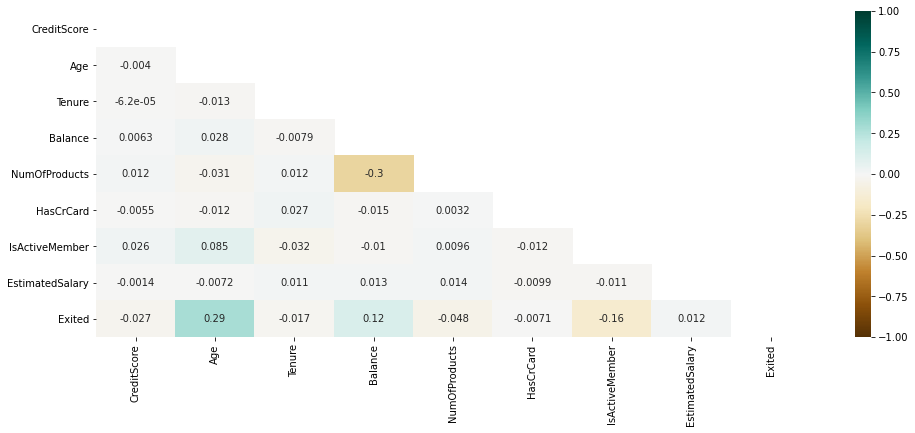

Столбцы: 

RowNumber - Индекс строки в данных

Описание данных:
count   10,000.00
mean     5,000.50
std      2,886.90
min          1.00
25%      2,500.75
50%      5,000.50
75%      7,500.25
max     10,000.00
Name: RowNumber, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

CustomerId - Уникальный идентификатор клиента

Описание данных:
count       10,000.00
mean    15,690,940.57
std         71,936.19
min     15,565,701.00
25%     15,628,528.25
50%     15,690,738.00
75%     15,753,233.75
max     15,815,690.00
Name: CustomerId, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

Surname - Фамилия

Описание данных:
count     10000
unique     2932
top       Smith
freq         32
Name: Surname, dtype: object
Количество записей: 10000 из 10000

Тип:
 <class 'str'>

CreditScore - Кредитный рейтинг

Описание данных:
count   10,000.00
mean       650.53
std         96.65
min        350.00
25%        584.00
50%        652.00
75%        71

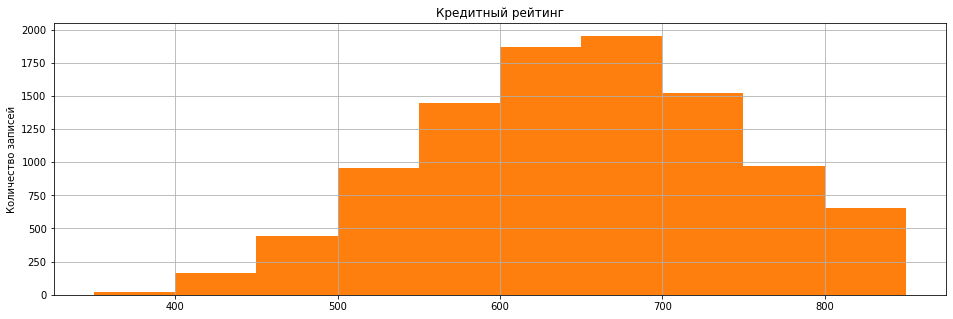


Geography - Страна проживания

Описание данных:
count      10000
unique         3
top       France
freq        5014
Name: Geography, dtype: object
Количество записей: 10000 из 10000

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Geography,cnt
0,France,5014
1,Germany,2509
2,Spain,2477



Гистограмма значений:


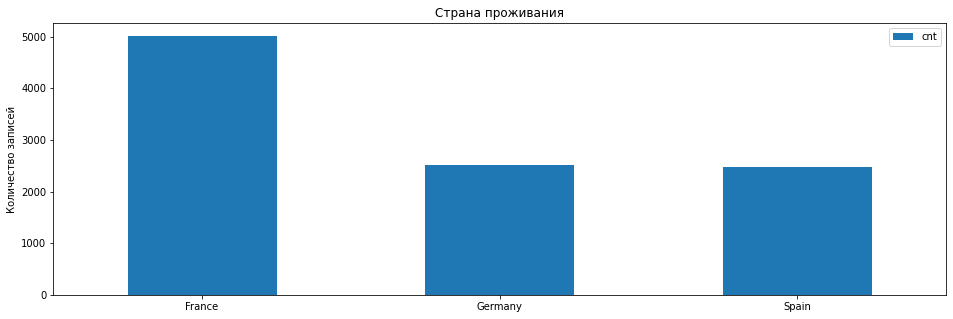


Gender - Пол

Описание данных:
count     10000
unique        2
top        Male
freq       5457
Name: Gender, dtype: object
Количество записей: 10000 из 10000

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


,Gender,cnt
0,Male,5457
1,Female,4543



Гистограмма значений:


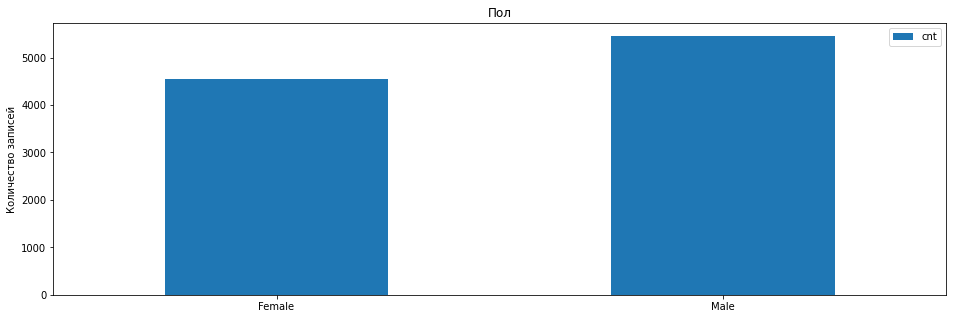


Age - Возраст

Описание данных:
count   10,000.00
mean        38.92
std         10.49
min         18.00
25%         32.00
50%         37.00
75%         44.00
max         92.00
Name: Age, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


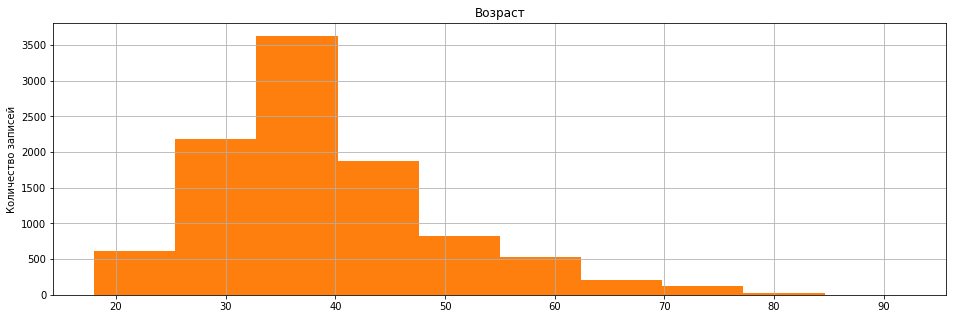


Tenure - Сколько лет человек является клиентом банка

Описание данных:
count   9,091.00
mean        5.00
std         2.89
min         0.00
25%         2.00
50%         5.00
75%         7.00
max        10.00
Name: Tenure, dtype: float64
Количество записей: 9091 из 10000
Пропущено: 909


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


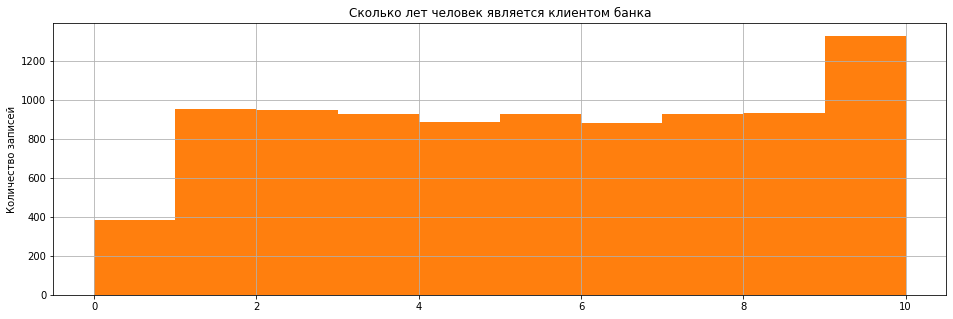


Balance - Баланс на счёте

Описание данных:
count    10,000.00
mean     76,485.89
std      62,397.41
min           0.00
25%           0.00
50%      97,198.54
75%     127,644.24
max     250,898.09
Name: Balance, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


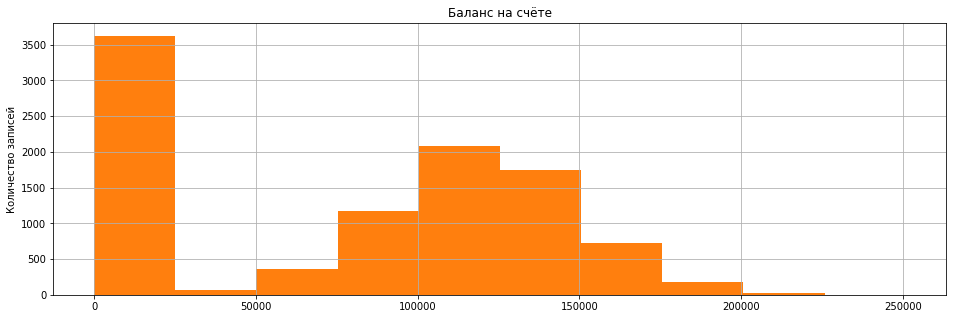


NumOfProducts - Количество продуктов банка, используемых клиентом

Описание данных:
count   10,000.00
mean         1.53
std          0.58
min          1.00
25%          1.00
50%          1.00
75%          2.00
max          4.00
Name: NumOfProducts, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


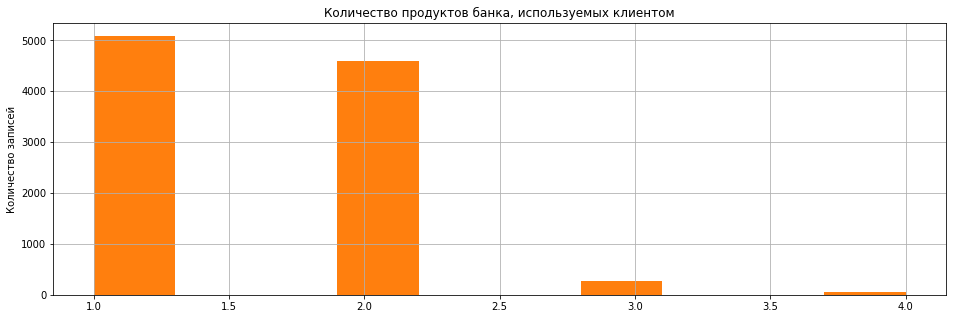


HasCrCard - Наличие кредитной карты

Описание данных:
count   10,000.00
mean         0.71
std          0.46
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          1.00
Name: HasCrCard, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


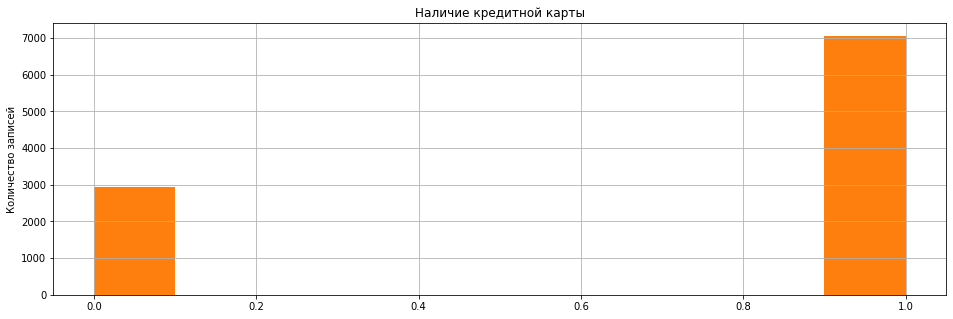


IsActiveMember - Активность клиента

Описание данных:
count   10,000.00
mean         0.52
std          0.50
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          1.00
Name: IsActiveMember, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


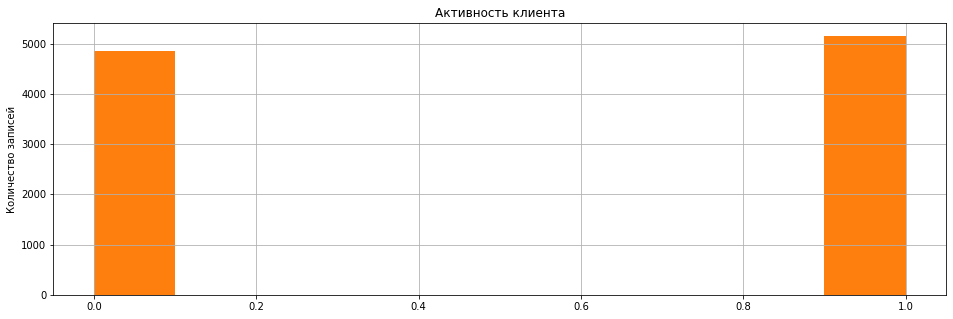


EstimatedSalary - Предполагаемая зарплата

Описание данных:
count    10,000.00
mean    100,090.24
std      57,510.49
min          11.58
25%      51,002.11
50%     100,193.91
75%     149,388.25
max     199,992.48
Name: EstimatedSalary, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


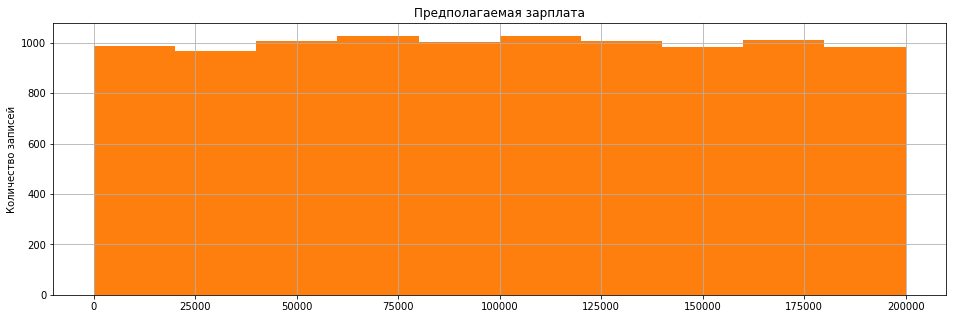


Exited - Факт ухода клиента

Описание данных:
count   10,000.00
mean         0.20
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: Exited, dtype: float64
Количество записей: 10000 из 10000

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


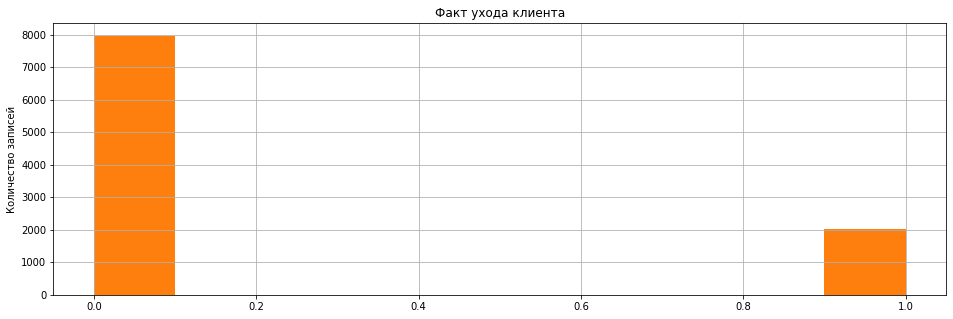

In [11]:
df_reaper(data, data_name, data_fields)

### Подготовка признаков

#### Удаление данных с пропусками

В  909 записях отсутствуют данные в столбце Tenure. Это составляет приблизительно 9% всех данных.
Восстановить эти данные по остальным данным  не получится. 
Данные в датасете распределены равномерно, без выбросов, поэтому эти 9% не повлияют на распределение данных .

В столбце Tenure у части записей отсутствуют данные.
Рассмотрим эти записи:

In [12]:
no_data = data.query('Tenure.isna()')
no_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,"140,469.38",1
48,49,15766205,Yin,550,Germany,Male,38,NaN,"103,391.38",1,0,1,"90,878.13",0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,"146,050.97",2,0,0,"86,424.57",0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,"125,561.97",1,0,0,"164,040.94",1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,"136,857.00",1,0,0,"84,509.57",0


Доля этих данных:

In [13]:
len(no_data)/len(data)

0.0909

Их всего 9%

Посмотрим долю ушедших клиентов из этой подборки:

In [14]:
no_data['Exited'].mean()

0.20132013201320131

Доля ушедших клиентов во всем датасете:

In [15]:
data['Exited'].mean()

0.2037

То есть, целевой признак среди этих данных распределен также, как и у всего набора.

9% данных, имеющих такое же распределение целевого признака, что и у всего набора данных, не повлияют на результат моделирования, поэтому их можно удалить:

In [16]:
data = data.dropna(subset=['Tenure'])

In [17]:
data = data.reset_index(drop=True)

In [18]:
len(data)

9091

#### Выделение признаков и целевого признака

In [19]:
data_fields

{'RowNumber': ['Индекс строки в данных', False],
 'CustomerId': ['Уникальный идентификатор клиента', False],
 'Surname': ['Фамилия', False],
 'CreditScore': ['Кредитный рейтинг', True],
 'Geography': ['Страна проживания', True],
 'Gender': ['Пол', True],
 'Age': ['Возраст', True],
 'Tenure': ['Сколько лет человек является клиентом банка', True],
 'Balance': ['Баланс на счёте', True],
 'NumOfProducts': ['Количество продуктов банка, используемых клиентом', True],
 'HasCrCard': ['Наличие кредитной карты', True],
 'IsActiveMember': ['Активность клиента', True],
 'EstimatedSalary': ['Предполагаемая зарплата', True],
 'Exited': ['Факт ухода клиента', True]}

Маловероятно, что поля:<br />
**RowNumber** - Индекс строки в данных,<br />
**CustomerId**- Уникальный идентификатор клиента,<br />
**Surname** - Фамилия<br />
влияют на решение клиента покинуть банк.<br />
Поэтому целесообразно не включать эти поля в признаки, которые будем использовать при анализе 

In [20]:
target = data['Exited'] 
features = data.drop(['RowNumber', 'CustomerId','Surname', 'Exited'], axis=1)

In [21]:
features

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88"
1,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58"
2,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57"
3,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63"
4,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10"
...,...,...,...,...,...,...,...,...,...,...
9086,800,France,Female,29,2.00,0.00,2,0,0,"167,773.55"
9087,771,France,Male,39,5.00,0.00,2,1,0,"96,270.64"
9088,516,France,Male,35,10.00,"57,369.61",1,1,1,"101,699.77"
9089,709,France,Female,36,7.00,0.00,1,0,1,"42,085.58"


#### Разбивка датасета  на тренировочную, валидационную и тестовую выборку в пропорции 60:20:20

In [22]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify = target_valid_test)

Проверка:

In [23]:
len(features_train)/len(features)

0.5999340006599934

In [24]:
len(features_valid)/len(features)

0.1999780002199978

In [25]:
len(features_test)/len(features)

0.2000879991200088

#### OHE

Произведем прямое кодирование для столбцов: "Пол" и "Страна проживания"

In [26]:
#features = pd.get_dummies(features, columns=['Gender','Geography'], drop_first=True)

 Столбцы, для которых мы будем проводить OHE:

In [27]:
ohe_columns=['Gender','Geography']

Обучение OHE:

In [28]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

In [29]:
encoder_ohe.fit(features_train[ohe_columns])

OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [30]:
new_columns = encoder_ohe.get_feature_names_out()
new_columns

array(['Gender_Male', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

Кодировка обучающей выборки:

In [31]:
features_train[new_columns] = encoder_ohe.transform(features_train[ohe_columns])
features_train = features_train.drop(ohe_columns, axis=1)

In [32]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
8837,526,32,7.00,"125,540.05",1,0,0,"86,786.41",1.00,0.00,0.00
1090,500,47,8.00,"128,486.11",1,1,0,"179,227.12",0.00,0.00,1.00
7609,802,40,4.00,0.00,2,1,1,"81,908.09",1.00,0.00,1.00
7279,731,39,2.00,"126,816.18",1,1,1,"74,850.93",0.00,0.00,1.00
2245,612,26,4.00,0.00,2,1,1,"179,780.74",0.00,0.00,1.00


Кодировка валидационной выборки:

In [33]:
features_valid[new_columns] = encoder_ohe.transform(features_valid[ohe_columns])
features_valid = features_valid.drop(ohe_columns, axis=1)

In [34]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
6800,610,37,10.00,"140,363.95",2,1,1,"129,563.86",0.00,0.00,1.00
4950,661,41,5.00,"122,552.48",2,0,1,"120,646.40",1.00,1.00,0.00
8287,753,51,4.00,"79,811.72",2,0,1,"68,260.27",1.00,0.00,1.00
8912,569,30,3.00,"139,528.23",1,1,1,"33,230.37",0.00,0.00,1.00
8265,597,38,6.00,"115,702.67",2,1,1,"25,059.05",1.00,0.00,1.00


Кодировка тестовой выборки:

In [35]:
features_test[new_columns] = encoder_ohe.transform(features_test[ohe_columns])
features_test = features_test.drop(ohe_columns, axis=1)

In [36]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
3726,675,32,10.00,0.00,2,1,0,"191,545.65",1.00,0.00,1.00
4661,784,38,1.00,"138,515.02",1,1,1,"171,768.76",1.00,1.00,0.00
8400,644,49,10.00,0.00,2,1,1,"145,089.64",1.00,0.00,1.00
6135,717,36,2.00,"102,989.83",2,0,1,"49,185.57",1.00,0.00,1.00
8853,677,25,3.00,0.00,2,1,0,"179,608.96",0.00,0.00,0.00


#### Масштабирование числовых признаков

Числовые признаки:

In [37]:
numeric = ['CreditScore', 'Age', 'Tenure','Balance', 'NumOfProducts','EstimatedSalary']

Масштабирование:

In [38]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [39]:
features_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
8837,-1.29,-0.66,0.69,0.79,-0.91,0,0,-0.22,1.00,0.00,0.00
1090,-1.56,0.78,1.03,0.83,-0.91,1,0,1.38,0.00,0.00,1.00
7609,1.58,0.11,-0.36,-1.22,0.79,1,1,-0.31,1.00,0.00,1.00
7279,0.84,0.01,-1.05,0.81,-0.91,1,1,-0.43,0.00,0.00,1.00
2245,-0.40,-1.24,-0.36,-1.22,0.79,1,1,1.39,0.00,0.00,1.00


In [40]:
features_valid.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
6800,-0.42,-0.18,1.73,1.02,0.79,1,1,0.52,0.00,0.00,1.00
4950,0.11,0.20,-0.01,0.74,0.79,0,1,0.36,1.00,1.00,0.00
8287,1.07,1.16,-0.36,0.05,0.79,0,1,-0.55,1.00,0.00,1.00
8912,-0.85,-0.85,-0.71,1.01,-0.91,1,1,-1.15,0.00,0.00,1.00
8265,-0.55,-0.09,0.34,0.63,0.79,1,1,-1.30,1.00,0.00,1.00


In [41]:
features_test.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
3726,0.26,-0.66,1.73,-1.22,0.79,1,0,1.60,1.00,0.00,1.00
4661,1.39,-0.09,-1.40,0.99,-0.91,1,1,1.25,1.00,1.00,0.00
8400,-0.06,0.97,1.73,-1.22,0.79,1,1,0.79,1.00,0.00,1.00
6135,0.70,-0.28,-1.05,0.43,0.79,0,1,-0.88,1.00,0.00,1.00
8853,0.28,-1.33,-0.71,-1.22,0.79,1,0,1.39,0.00,0.00,0.00


#### Расчёт дисбаланса

In [42]:
target_train.value_counts(normalize=True)

0   0.80
1   0.20
Name: Exited, dtype: float64

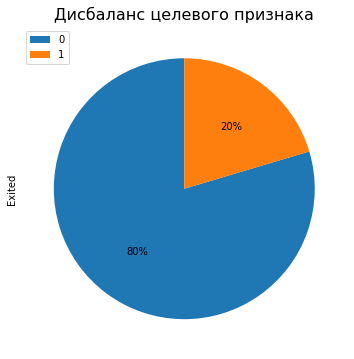

In [43]:
target_train.value_counts(normalize=True).plot(kind='pie', y='Exited', autopct='%1.0f%%', 
                                               figsize=(6,6), startangle=90, labeldistance=None)
plt.title('Дисбаланс целевого признака', fontsize=16)
plt.legend()
plt.show()

### Выводы

**I Анализ датасета:<br/>**
1. Датасет содержит 10000 записей. Данные не содержат выбросов, 9% записей содержат пропуски данных.<br/><br/>
2. Присутствует слабая корелляция (0.29) между возрастом клиентов и фактом ухода <br/>
Присутствует незначительная обратная корелляция (-0.16) между активностью клиента и фактом ухода.<br/><br/>
3.Характеристика клиентов:
- Пол: мужчины - 5457, женщины - 4543;<br/>
- Возраст: от 18 до 92 лет (медиана - 37 лет);<br/>
- Страны проживания: Франция(5014), Германия(2509), Испания(2477);<br/>
- Предполагаемая зарплата: от 0 до 200 000 (медиана - 100 000);<br/>
- Являются клиентами банка от 0 до 10 лет (медиана - 5 лет);<br/>
- Кредитный рейтинг: от 350 до 850;<br/>
- Не имеют вкладов в банке больше 35%, остальные имеют вклады до 250 000 (медиана - около 100 000);<br/>
- 50% клиентов пользуются одним банковским продуктом, 45 - двумя, остальные 3 и 4;<br/>
- Кредитная карта есть у 75% клиентов;<br/>
- Активных клиентов - 52%<br/>
4. Из банка ушло 20% клиентов. "Немного, но заметно"(с)<br/>

**II Подготовка признаков:<br/>**
1. Удалено 909 записей (около 9%), содержащих неполные данные.
2. Выделены признаки и целевой признак
3. Произведено прямое кодирование признаков "Пол" и "Страна проживания"
4. Датасет разбит на обучающую, валидационную и тестовую выборку
5. Произведено масштабирование числовых признаков в каждой из выборок
6. В целевом признаке присутствует дисбаланс (1:4)

## **Исследование задачи**

**Проверка влияния дисбаланса на результат**

Целевой признак не сбалансирован. Но влияет ли это на результат? <br />
Для начала  используем фальшивую модель DummyClassifier для получения статистического результата.<br /> 
После чего посмотрим модели  "Решающее дерево", "Случайный лес" и "Логистическая регрессия" на валидационной выборке и оценим их метрикой F1.<br /> 
Для проверки адекватности модели, применим метрику accuracy.

### Модель **DummyClassifier**

Поскольку результат бинарен, достаточно использовать стратегии 'most_frequent', 'stratified','uniform' и 'constant' при constant=1 (стратегия 'prior' при наиболее распространенном 0 будет выдавать тот же результат, что и  'most_frequent')

In [44]:
strategies = ['most_frequent','stratified', 'uniform','constant', 'prior']  
print('Стратегия \t F1 \t AUC-ROC')  
for s in strategies:
    dclf = DummyClassifier(strategy = s, random_state = 12345,constant=1)
    dclf.fit(features_train, target_train)
    predictions_dummy = dclf.predict(features_valid)
    probabilities_valid = dclf.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print(s,'\t', f1_score(target_valid,predictions_dummy), '\t', roc_auc_score(target_valid, probabilities_one_valid))    
    

Стратегия 	 F1 	 AUC-ROC
most_frequent 	 0.0 	 0.5
stratified 	 0.20772303595206393 	 0.5007674582787698
uniform 	 0.2560124127230411 	 0.5
constant 	 0.33896756509821835 	 0.5
prior 	 0.0 	 0.5


Лучший результат (0.339) даёт модель 'constant' при constant=1. Значение метрики F1 для нее мы и будем использовать, как критерий адекватности.

### Модель **"Решающее дерево"**

#### Поиск оптимальных гиперпараметров:

In [45]:
%%time
best_model = None
best_result = 0
for depth in range(1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
model_tree = best_model
model_tree  

CPU times: user 3.4 s, sys: 672 µs, total: 3.4 s
Wall time: 3.41 s


DecisionTreeClassifier(max_depth=7, random_state=12345)

#### F1 наилучшей модели на валидационной выборке:

In [46]:
 best_result 

0.587248322147651

Модель адекватна, но значение F1 меньше минимально приемлемого (0.59).

#### Метрика AUC-ROC для данной модели:

In [47]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8280315999083522

### Модель **"Случайный лес"**

#### Поиск оптимальных гиперпараметров:

In [48]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid,predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
model_forest = best_model
model_forest

CPU times: user 3min 8s, sys: 1.22 s, total: 3min 9s
Wall time: 3min 10s


RandomForestClassifier(max_depth=14, n_estimators=32, random_state=12345)

#### F1 наилучшей модели на валидационной выборке:

In [49]:
 best_result

0.6298701298701298

Модель адекватна, значение F1 немного больше минимально приемлемого (0.59)

#### Метрика AUC-ROC для данной модели:

In [50]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8673573170254658

### Модель **"Логистическая регрессия"**

#### Обучение модели:

In [51]:
model_regress = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_regress.fit(features_train, target_train)
model_regress

LogisticRegression(max_iter=1000, random_state=12345)

#### F1 модели на валидационной выборке:

In [52]:
predictions_valid = model_regress.predict(features_valid)
f1_score(target_valid,predictions_valid)

0.3306772908366534

Модель неадекватна: значение F1 немного меньше, чем у dummy-модели (0.339)

#### Метрика AUC-ROC для данной модели:

In [53]:
probabilities_valid = model_regress.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.7893382907660986

### **Выводы:**

1. Наилучший результат показала модель "Случайный лес" с параметрами max_depth=14, n_estimators=32, random_state=12345:<br />
F1 = 0.630, AUC-ROC = 0.869. Она уже приемлема, но попробуем улучшить результат.
2. Модель "Решающее дерево" адекватна, но показала результат ниже минимально приемлемого.
3. Модель "Логистическая регрессия" неадекватна.

## **Борьба с дисбалансом**

### **Взвешивание классов**

Придадим объектам редкого класса ("1") больший вес.

#### Модель **"Решающее дерево"**

##### Поиск оптимальных гиперпараметров:

In [54]:
%%time
best_model = None
best_result = 0
for depth in range(1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
model_tree = best_model
model_tree  

CPU times: user 3.46 s, sys: 7.95 ms, total: 3.47 s
Wall time: 3.48 s


DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)

##### F1 наилучшей модели на валидационной выборке:

In [55]:
 best_result

0.583084577114428

Модель адекватна, значение F1 немного уменьшилось, и все также меньше минимально приемлемого (0.59)

##### Метрика AUC-ROC для данной модели:

In [56]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8355133867449523

#### Модель **"Случайный лес"**

##### Поиск оптимальных гиперпараметров:

In [57]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid,predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
model_forest = best_model
model_forest

CPU times: user 3min 4s, sys: 1.02 s, total: 3min 5s
Wall time: 3min 6s


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=44,
                       random_state=12345)

##### F1 наилучшей модели на валидационной выборке:

In [58]:
 best_result

0.6497326203208557

Модель адекватна, значение F1 увеличилось на 1.5% и остаётся немного большим минимально приемлемого (0.59)

##### Метрика AUC-ROC для данной модели:

In [59]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8680623727500153

#### Модель **"Логистическая регрессия"**

##### Обучение модели:

In [60]:
model_regress = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000, class_weight='balanced')
model_regress.fit(features_train, target_train)
model_regress

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345)

##### F1 модели на валидационной выборке:

In [61]:
predictions_valid = model_regress.predict(features_valid)
f1_score(target_valid,predictions_valid)

0.5079365079365079

Модель стала адекватной, значение F1 увеличилось в 1.5 раза, но все еще меньше минимально приемлемого (0.59)

##### Метрика AUC-ROC для данной модели:

In [62]:
probabilities_valid = model_regress.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.7907428139267598

#### Выводы:

1. При использовании взвешивания классов наилучший результат показала модель "Случайный лес" с параметрами class_weight='balanced', max_depth=10, n_estimators=44, random_state=12345:<br />
F1 = 0.650, AUC-ROC = 0.868.<br />
Она уже приемлема, но попробуем улучшить результат.
2. Остальные 2 модели показывают результат ниже минимально приемлемого

### **Увеличение выборки**

#### Функция увеличения выборки

In [63]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [64]:
Counter(target_train)

Counter({0: 4342, 1: 1112})

In [65]:
sm = SMOTE(random_state=12345)
features_upsampled, target_upsampled = sm.fit_resample(features_train, target_train)

In [66]:
Counter(target_upsampled)

Counter({0: 4342, 1: 4342})

In [67]:
#features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#### Модель **"Решающее дерево"**

##### Поиск оптимальных гиперпараметров:

In [68]:
%%time
best_model = None
best_result = 0
for depth in range(1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
model_tree = best_model
model_tree  

CPU times: user 5.62 s, sys: 4.02 ms, total: 5.63 s
Wall time: 5.65 s


DecisionTreeClassifier(max_depth=7, random_state=12345)

##### F1 наилучшей модели на валидационной выборке:

In [69]:
 best_result

0.5893958076448829

F1 полностью совпадает с результатом модели с взвешиванием классов

##### Метрика AUC-ROC для данной модели:

In [70]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8167032078638395

#### Модель **"Случайный лес"**

##### Поиск оптимальных гиперпараметров:

In [71]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid,predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
model_forest = best_model
model_forest

CPU times: user 4min 43s, sys: 1.32 s, total: 4min 44s
Wall time: 4min 45s


RandomForestClassifier(max_depth=11, n_estimators=48, random_state=12345)

##### F1 наилучшей модели на валидационной выборке:

In [72]:
 best_result

0.6544021024967148

F1 незначительно улучшилось по сравнению с результатом модели с взвешиванием классов

##### Метрика AUC-ROC для данной модели:

In [73]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.87517812669395

#### Модель **"Логистическая регрессия"**

##### Обучение модели:

In [74]:
model_regress = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_regress.fit(features_upsampled, target_upsampled)
model_regress

LogisticRegression(max_iter=1000, random_state=12345)

##### F1 модели на валидационной выборке:

In [75]:
predictions_valid = model_regress.predict(features_valid)
f1_score(target_valid,predictions_valid)

0.5004812319538018

F1 незначительно ухудшилось по сравнению с результатом модели с взвешиванием классов

##### Метрика AUC-ROC для данной модели:

In [76]:
probabilities_valid = model_regress.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.7857710999800684

#### Выводы:

1. При использовании увеличения выборки наилучший результат показала модель "Случайный лес" с параметрами max_depth=11, n_estimators=48, random_state=12345:<br />
F1 = 0.654, AUC-ROC = 0.875.<br />
Она уже приемлема, но попробуем улучшить результат.
2. Остальные 2 модели показывают результат ниже минимально приемлемого

### **Уменьшение выборки**

#### Функция уменьшения выборки

In [77]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [78]:
Counter(target_train)

Counter({0: 4342, 1: 1112})

In [79]:
rus = RandomUnderSampler(random_state=12345)
features_downsampled, target_downsampled = rus.fit_resample(features_train, target_train)

In [80]:
Counter(target_downsampled)

Counter({0: 1112, 1: 1112})

In [81]:
#features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#### Модель **"Решающее дерево"**

##### Поиск оптимальных гиперпараметров:

In [82]:
%%time
best_model = None
best_result = 0
for depth in range(1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid,predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
model_tree = best_model
model_tree  

CPU times: user 1.98 s, sys: 31.9 ms, total: 2.01 s
Wall time: 2.02 s


DecisionTreeClassifier(max_depth=4, random_state=12345)

##### F1 наилучшей модели на валидационной выборке:

In [83]:
 best_result

0.5623721881390594

Значение ухудшилось относительно 2-х предыдущих способов балансировки

##### Метрика AUC-ROC для данной модели:

In [84]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.827097424357859

#### Модель **"Случайный лес"**

##### Поиск оптимальных гиперпараметров:

In [85]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1,61, 1):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid,predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
model_forest = best_model
model_forest

CPU times: user 2min 37s, sys: 925 ms, total: 2min 38s
Wall time: 2min 40s


RandomForestClassifier(max_depth=9, n_estimators=52, random_state=12345)

##### F1 наилучшей модели на валидационной выборке:

In [86]:
 best_result

0.628755364806867

Значение ухудшилось относительно 2-х предыдущих способов балансировки

##### Метрика AUC-ROC для данной модели:

In [87]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8787732589221682

#### Модель **"Логистическая регрессия"**

##### Обучение модели:

In [88]:
model_regress = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_regress.fit(features_downsampled, target_downsampled)
model_regress

LogisticRegression(max_iter=1000, random_state=12345)

##### F1 модели на валидационной выборке:

In [89]:
predictions_valid = model_regress.predict(features_valid)
f1_score(target_valid,predictions_valid)

0.5139664804469274

Значение незначительно ухудшилось относительно 2-х  способа балансировки "Увеличение выборки"

##### Метрика AUC-ROC для данной модели:

In [90]:
probabilities_valid = model_regress.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.7910948760983315

#### Выводы:

1. При использовании уменьшения выборки наилучший результат показала модель "Случайный лес" с параметрами max_depth=9, n_estimators=52, random_state=12345:<br />
F1 = 0.629, AUC-ROC = 0.879.<br />
Она уже приемлема, но хуже результата при увеличении выборки.
2. Остальные 2 модели показывают результат ниже минимально приемлемого

### **Изменение порога классификации**

Возьмем лучшие из сбалансированных и несбалансированных моделей и подберем им оптимальный порог

#### Модель **"Решающее дерево"**

Для модели "Решающее дерево" лучшее значение F1 было при увеличении обучающей выборки с параметрами random_state=12345, max_depth=7: 0.589 при значении AUC-ROC = 0.817<br />
Применим для нее взвешивание классов и подберем порог

In [91]:
%%time
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > max_f1:
        max_f1 = f1
        max_roc_auc = roc_auc
        max_trh = threshold
print("Порог = {:.2f} | F1 = {:.3f}, AUC-ROC = {:.3f}".format(max_trh, max_f1, max_roc_auc))

Порог = 0.68 | F1 = 0.593, AUC-ROC = 0.817
CPU times: user 406 ms, sys: 3.94 ms, total: 410 ms
Wall time: 416 ms


При пороге 0.68 значение F1 увеличилось до 0.593 и превысило минимально приемлемое (0.59)!

Сравним ее с лучшей моделью без балансировки:

In [92]:
%%time
model = DecisionTreeClassifier(random_state=12345, max_depth=7)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > max_f1:
        max_f1 = f1
        max_roc_auc = roc_auc
        max_trh = threshold
print("Порог = {:.2f} | F1 = {:.3f}, AUC-ROC = {:.3f}".format(max_trh, max_f1, max_roc_auc))

Порог = 0.39 | F1 = 0.602, AUC-ROC = 0.828
CPU times: user 512 ms, sys: 3.85 ms, total: 516 ms
Wall time: 527 ms


Значения F1 и AUC-ROC оказались лучше на модели без балансировки

#### Модель **"Случайный лес"**

Для модели "Случайный лес" лучшее значение F1 было при увеличении обучающей выборки с параметрами max_depth=11, n_estimators=48, random_state=12345: 0.654 при значении AUC-ROC = 0.875

In [93]:
%%time
model = RandomForestClassifier(random_state=12345, n_estimators=48, max_depth=11)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > max_f1:
        max_f1 = f1
        max_roc_auc = roc_auc
        max_trh = threshold
print("Порог = {:.2f} | F1 = {:.3f}, AUC-ROC = {:.3f}".format(max_trh, max_f1, max_roc_auc))

Порог = 0.50 | F1 = 0.654, AUC-ROC = 0.875
CPU times: user 965 ms, sys: 19.9 ms, total: 985 ms
Wall time: 987 ms


Данная модель не требует изменения порога

Сравним ее с лучшей моделью без балансировки:

In [94]:
%%time
model = RandomForestClassifier(random_state=12345, n_estimators=32, max_depth=14)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > max_f1:
        max_f1 = f1
        max_roc_auc = roc_auc
        max_trh = threshold
print("Порог = {:.2f} | F1 = {:.3f}, AUC-ROC = {:.3f}".format(max_trh, max_f1, max_roc_auc))

Порог = 0.34 | F1 = 0.660, AUC-ROC = 0.867
CPU times: user 756 ms, sys: 3.94 ms, total: 760 ms
Wall time: 771 ms


Значение F1 увеличилось, а AUC-ROC - незначительно уменьшились

#### Модель **"Логистическая регрессия"**

Для модели "Логистическая регрессия" лучшее значение F1 было при уменьшении обучающей выборки:  0.508 при значении AUC-ROC =
    0.791<br />

In [95]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
for threshold in np.arange (0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > max_f1:
        max_f1 = f1
        max_roc_auc = roc_auc
        max_trh = threshold
print("Порог = {:.2f} | F1 = {:.3f}, AUC-ROC = {:.3f}".format(max_trh, max_f1, max_roc_auc))

Порог = 0.56 | F1 = 0.522, AUC-ROC = 0.791


Данные модели улучшились, но минимально приемлемое значение (0.59) не достигнуто.

Сравним ее с моделью без балансировки:

In [96]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    if f1 > max_f1:
        max_f1 = f1
        max_roc_auc = roc_auc
        max_trh = threshold
print("Порог = {:.2f} | F1 = {:.3f}, AUC-ROC = {:.3f}".format(max_trh, max_f1, max_roc_auc))

Порог = 0.28 | F1 = 0.532, AUC-ROC = 0.789


F1 незначительно улучшилось, AUC-ROC незначительно ухудшилось....

### **Выводы:**

1. Балансировка благотворно влияет метрику F1 и практически не влияет на метрику AUC-ROC.
2. Среди способов борьбы с дисбалансом наиболее эффективным показало себя изменение порога классификации.
3. Наилучший результат показала модель "Случайный лес" с параметрами random_state=12345, n_estimators=32, max_depth=14, построенная на обучающей выборке, с порогом, измененным до 0.34: F1 = 0.660, AUC-ROC = 0.867<br />

## **Тестирование модели**

### Протестируем нашу лучшую модель на тестовых данных:

In [97]:
%%time
model = RandomForestClassifier(random_state=12345, n_estimators=32, max_depth=14)
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.34
f1 = f1_score(target_test,predicted_test)
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print("F1 = {:.3f}, AUC-ROC = {:.3f}".format(f1, roc_auc))

F1 = 0.603, AUC-ROC = 0.843
CPU times: user 307 ms, sys: 11.9 ms, total: 319 ms
Wall time: 329 ms


F1 на тестовых данных ухудшилось на 9%, AUC-ROC - на 3%, что показывает высокое качество построенной модели.

### ROC-кривая для нашей модели:

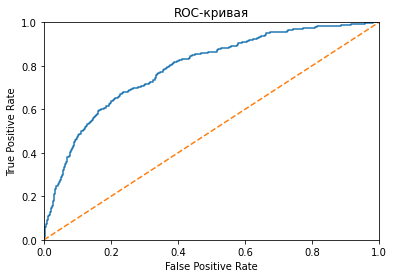

In [98]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


ROC-кривая выбранной модели значительно выше графика случайной модели, что показывает ее адекватность. Соответственно, площадь под кривой, она же метрика AUC-ROC, равная 0.867 значительно больше площади под кривой случайной модели (0.5)

### Выводы:

1. Выбранная модель остается корректной на тестовой выборке 
2. График ROC-кривой показывает ее адекватность.

## **Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

## **Итоги проекта:**

**I. Подготовка данных**
1. Исследованы данные в исходном датасете:<br />
Исходный датасет содержит 10000 записей о клиентах банка. Данные не содержат выбросов, 9% записей содержат пропуски данных.

2. Подготовлены признаки:
- Удалено 909 записей (около 9%), содержащих неполные данные.
- Выделены признаки и целевой признак
- Произведено прямое кодирование признаков "Пол" и "Страна проживания"
- Датасет разбит на обучающую, валидационную и тестовую выборку
- Произведено масштабирование числовых признаков в каждой из выборок
3. В целевом признаке присутствует дисбаланс (1:4)

**II Исследование задачи**
1. Построена модель DummyClassifier для проверки адекватности получаемых моделей.
2. Построены модели "Решающее дерево", "Случайный лес" и "Логистическая регрессия", для которых были подобраны гиперпараметры для получения максимальной метрики F1.<br />  
Наилучший результат показала модель "Случайный лес" с параметрами max_depth=14, n_estimators=32, random_state=12345:
F1 = 0.630, AUC-ROC = 0.869. 

**III. Борьба с дисбалансом**

1. Для каждого из трех типов моделей были произведены взвешивание классов, увеличение и уменьшение обучающей выборки, изменение порога классификации. Для данной задачи изменение порога классификации показало себя наиболее эффективным.
2. Наилучший результат показала модель "Случайный лес" с параметрами random_state=12345, n_estimators=32, max_depth=14, с порогом, измененным до 0.34: F1 = 0.660, AUC-ROC = 0.867, которая и выбирается для дальнейшего тестирования.
3. Балансировка благотворно влияет метрику F1 и не влияет на метрику AUC-ROC.

**IV. Тестирование модели**
1. Выбранная модель остается корректной на тестовой выборке: на тестовых данных F1 = 0.603, AUC-ROC = 0.843
2. График ROC-кривой показывает ее адекватность.

**V. Итог:**<br /><br />
Для прогноза ухода клиентов из банка рекомендуется использовать модель "Случайный лес" с параметрами random_state=12345, n_estimators=32, max_depth=14, с порогом, измененным до 0.34.